In [138]:
import pickle
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pyLDAvis.sklearn
import json
import glob
import os
import pprint
import re
import string
import nltk
import warnings
import networkx as nx
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [95]:
TWEETS_DIR = '/Users/matt/Downloads/sma/final_paper/Twitter-Networks/tweets'

DATA = [json.load(open(json_file, 'r')) for json_file in glob.glob(os.path.join(TWEETS_DIR, '*.json'))]
TWEETS = [tweet for user in DATA for tweet in user['tweets']]

print('Tweets loaded: ' + str(len(TWEETS)))

Tweets loaded: 95962


In [96]:
def sweep_tweets(tweets):
    clean_tweets = []
    for tweet in tweets:
        tweet = re.sub(r'[.,"!]+', '', tweet, flags=re.MULTILINE)  # removes the characters specified
        tweet = re.sub(r'^RT[\s]+', '', tweet, flags=re.MULTILINE)  # removes RT
        tweet = re.sub(r'^rt[\s]+', '', tweet, flags=re.MULTILINE)  # removes RT
        tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)  # remove link https
        tweet = re.sub(r'http?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)  # remove link http
        tweet = re.sub(r'[:]+', '', tweet, flags=re.MULTILINE)
        tweet=tweet.replace('&amp','').replace(';amp;','')
        tweet = ''.join(filter(lambda x: x in string.printable, tweet))  # filter non-ascii characers

        clean_tweet = ''
        for i in tweet.split():  # remove @ and #words, punctuataion
            #if not i.startswith('@') and not i.startswith('#') and i not in string.punctuation:
            if not i.startswith('@') and i not in string.punctuation:
                clean_tweet += i + ' '
        tweet = clean_tweet
                            
        # Do sentence correction
        if tweet in clean_tweets:
            continue
        elif True:#len(nltk.word_tokenize(tweet)) > 100: # clean documents w/ less than 100 words total
            clean_tweets.append(tweet)
    return clean_tweets

#Clean junk from tweets
CLEAN_TWEETS = sweep_tweets(TWEETS)
print('Tweets Post-Filter: ' + str(len(CLEAN_TWEETS)))

Tweets Post-Filter: 81458


In [105]:
# Maximum number of top words to find in the dataset
MAX_FEATURES = 1000

# Max number of topics
N_COMPONENTS = 50

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [110]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=MAX_FEATURES, stop_words='english')
tf = tf_vectorizer.fit_transform(CLEAN_TWEETS)
tf_feature_names = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(n_components=N_COMPONENTS, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
topic_vis = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.display(topic_vis)

In [108]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=MAX_FEATURES, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(CLEAN_TWEETS)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

nmf = NMF(n_components=N_COMPONENTS, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, 30)

Topic 0:
people american government black country sick kill wake million british power lives young hate believe wrong killed getting democrats vote really racist pay killing used change dont working said evil
Topic 1:
la en el que los por una del las para se es al su lo ms ha son ya van civil 10 sexual real 25 yemen 2018 twitter 2017 13
Topic 2:
trump donald mueller russia maga supporters anti campaign president democrats says cnn kanye breaking cohen korea administration michael north paul plan tax dossier said dems peace john vote judge collusion
Topic 3:
just got said saying wow big real ve thought ll water let leave days really theory maybe years told little getting shit called work away fucking case started dont ago
Topic 4:
chemtrails theresamay clouds sky spraying opchemtrails morning sun nasa blue yesterday photo climatechange poison toxic west chemical photos air real does bit near maybe uk water 2018 low conspiracy normal
Topic 5:
syria war attack russia uk chemical israel sa

---

In [154]:
BASE_DIR = '/Users/matt/Downloads/sma/final_paper/Twitter-Networks'
TWEETS_DIRS = glob.glob(os.path.join(BASE_DIR, 'tweets_*'))
TOPICS = [os.path.split(folder)[1].replace('tweets_', '') for folder in TWEETS_DIRS]
USER_DATA = {}
for tweet_dir in TWEETS_DIRS:
    for json_file in glob.glob(os.path.join(tweet_dir, '*.json')):
        user_data = json.load(open(json_file, 'r'))
        user_id = user_data['user']
        user_tweets = user_data['tweets']
        if user_id not in USER_DATA.keys():
            USER_DATA[user_id] = []
        USER_DATA[user_id].extend(sweep_tweets(user_tweets))

In [155]:
G = nx.DiGraph()

for topic in TOPICS:
    G.add_node(topic, type='topic', tweets=[])
    
for user_id, user_tweets in USER_DATA.items():
    G.add_node(user_id, type='user')
    for tweet in user_tweets:
        for topic in TOPICS:
            if topic in tweet.lower():
                G.add_edge(user_id, topic)
                G.node[topic]['tweets'].append(tweet)

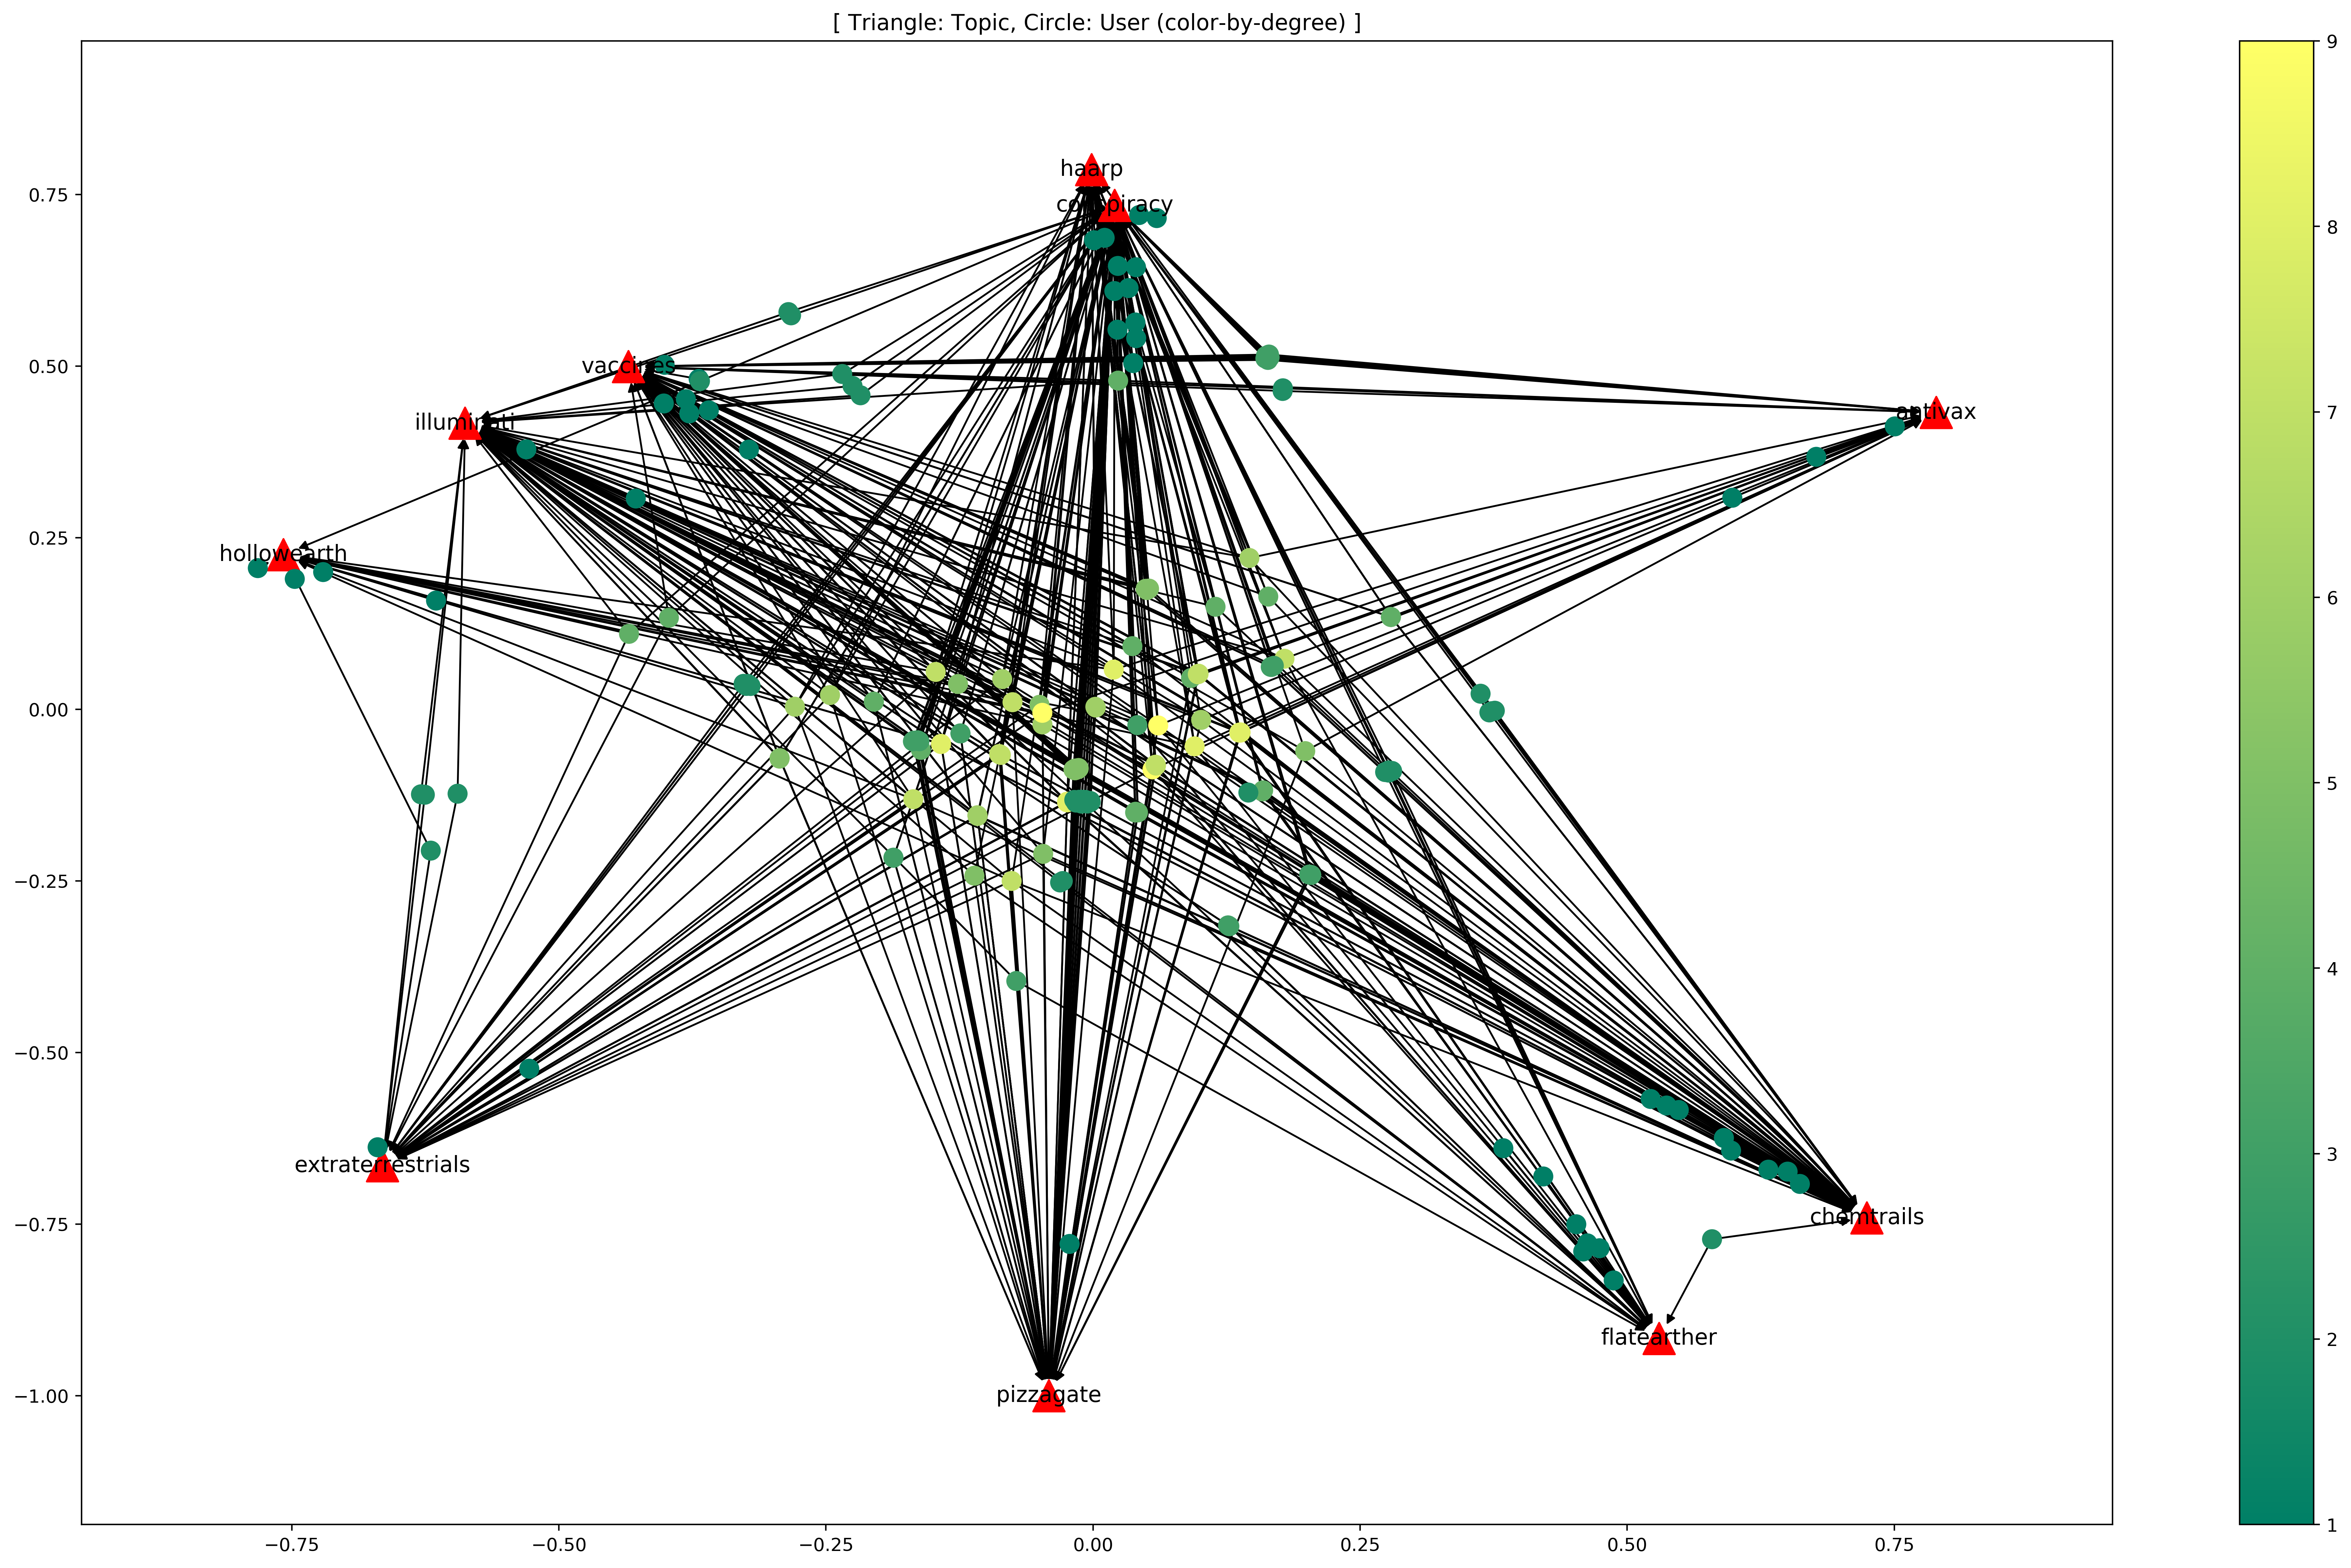

In [190]:
def convert_to_hex(rgba_color) :
    red = int(rgba_color[0]*255)
    green = int(rgba_color[1]*255)
    blue = int(rgba_color[2]*255)
    return '#%02x%02x%02x' % (red, green, blue)


def plot_users_and_topics(G):
    degree_max = max([G.degree(n) for n, d in G.nodes(data=True) if n and d['type'] == 'user'])
    cmap = plt.cm.summer
    norm = plt.Normalize(vmin=1, vmax=degree_max)
    m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    m._A = []

    post_colors = []
    user_colors = []
    topics = []
    users = []

    node_type = nx.get_node_attributes(G, 'type')
    for node, node_type in node_type.items():
        if node_type == 'topic':
            post_colors.append('red')
            topics.append(node)
        else:
            user_colors.append(convert_to_hex(m.to_rgba(len(G.edges(node)))))
            users.append(node)
    plt.figure(1, figsize=(25,15), dpi=400)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=topics, node_color=post_colors, with_labels=True, node_shape='^')
    label_dict = {}
    for topic in topics:
        label_dict[topic] = str(topic)
    for user in users:
        label_dict[user] = ''
    nx.draw_networkx_labels(G, pos, labels=label_dict)
    nx.draw_networkx_nodes(G, pos, nodelist=users, node_color=user_colors, with_labels=False, node_shape='o', node_size=100)
    nx.draw_networkx_edges(G, pos)
    plt.colorbar(m)
    plt.title('[ Triangle: Topic, Circle: User (color-by-degree) ]')
    plt.show()

plot_users_and_topics(G)

In [191]:
CLEAN_USER_TWEETS = []

for user_id, user_tweets in USER_DATA.items():
    CLEAN_USER_TWEETS.extend(user_tweets)

tf_vectorizer2 = CountVectorizer(max_df=0.95, min_df=2, max_features=MAX_FEATURES, stop_words='english')
tf2 = tf_vectorizer2.fit_transform(CLEAN_USER_TWEETS)
tf_feature_names2 = tf_vectorizer2.get_feature_names()

lda2 = LatentDirichletAllocation(n_components=N_COMPONENTS, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tf2)
topic_vis2 = pyLDAvis.sklearn.prepare(lda2, tf2, tf_vectorizer2)
pyLDAvis.display(topic_vis2)